In [5]:
import numpy as np
import scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # just making the notebook cells wider

from importlib import reload
import time

import warnings
warnings.filterwarnings("ignore")

import poppy
import hcipy as hci

import math_module
from math_module import xp
import iefc_2dm 
import utils
from imshows import *

math_module.update_np(np)
math_module.update_scipy(scipy)

data_dir = iefc_2dm.iefc_data_dir
response_dir = data_dir/'response-data'

import misc_funs as misc

import hcipy_models as hcim
reload(hcim)

reload(hci)
npix = 256
oversample = 2
c = hcim.SVC(npix=npix, oversample=oversample)



In [6]:
influence_functions = hci.make_gaussian_influence_functions(c.pupil_grid, c.Nact, c.actuator_spacing)


34 952


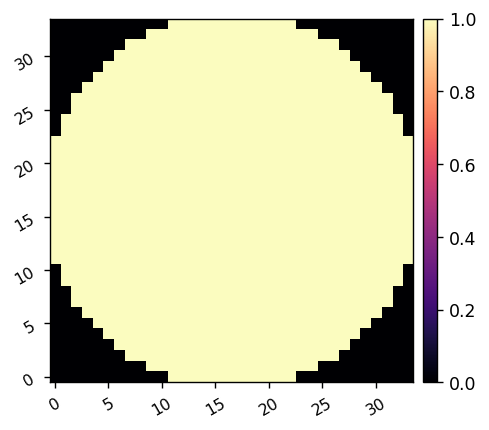

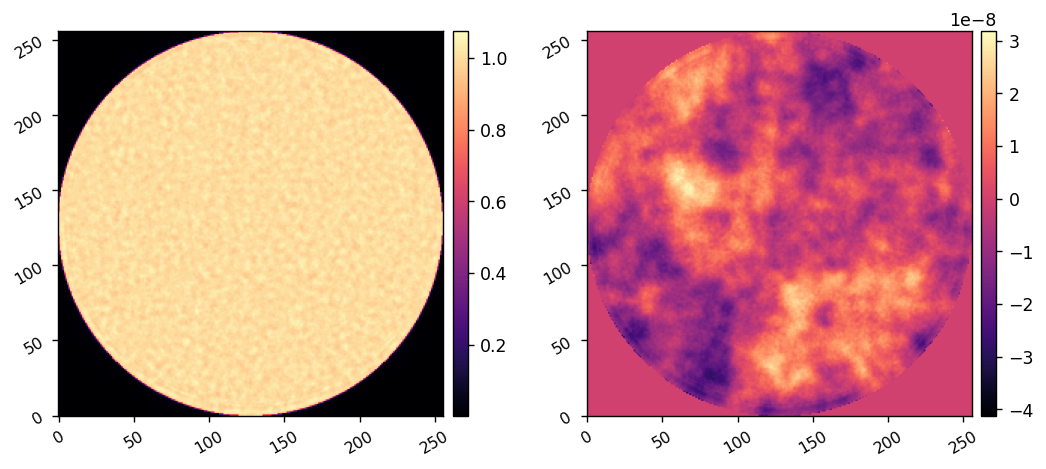

0.05890531586771707 9.705794728641807e-09


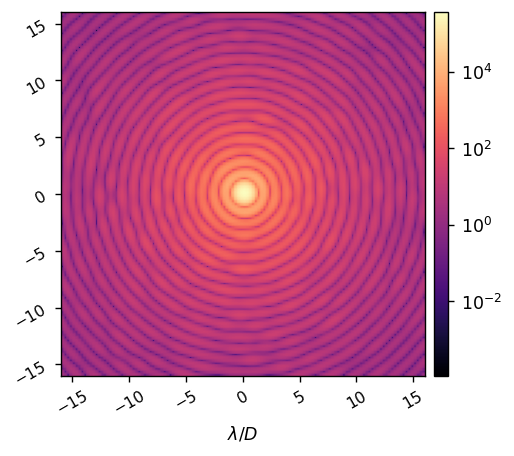

361441.78898338124


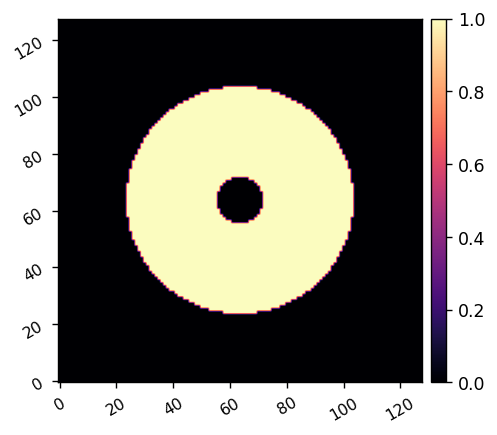

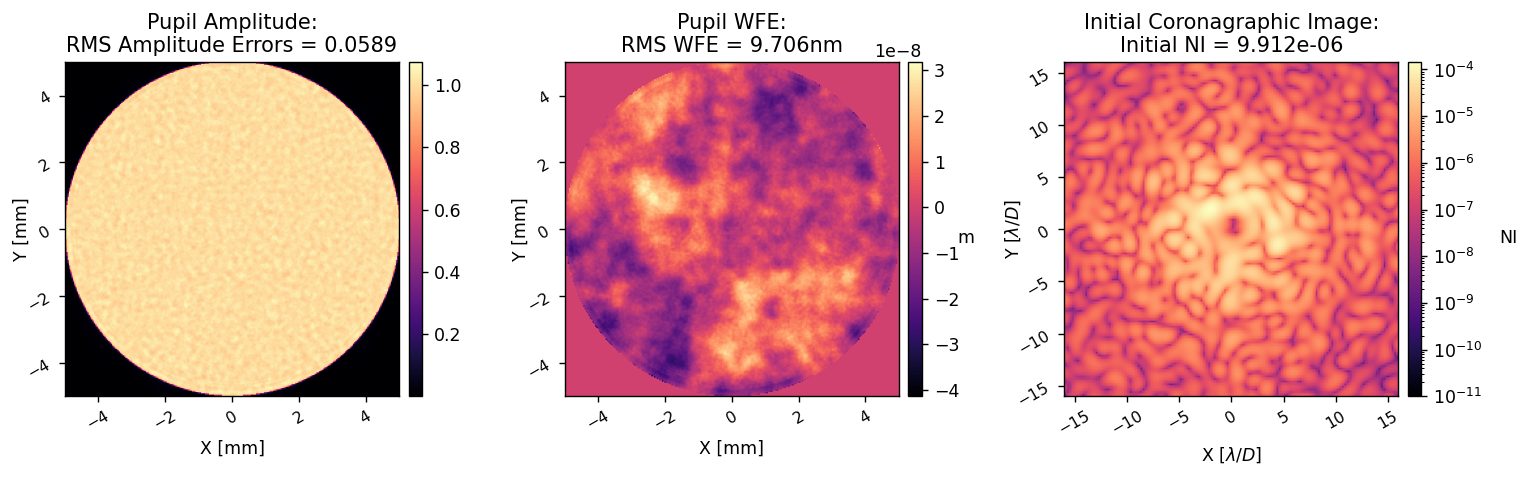

In [7]:
reload(hcim)
svc = hcim.SVC(npix=npix, oversample=oversample,
                 influence_functions=influence_functions,
                 ptv=50*u.nm,
                 psf_pixelscale_lamD=1/4,
                 dm1_dm2=300*u.mm,
                 aberration_distance=50e-3*u.m)

print(svc.Nact, svc.Nacts)
imshow1(svc.dm_mask)

wf = hci.Wavefront(svc.aperture, svc.wavelength.to_value(u.m))
pupil_mask = wf.amplitude.shaped.astype(bool)
wf = svc.wfe_at_distance(wf)

amp = wf.amplitude.shaped
opd = wf.phase.shaped*svc.wavelength.to_value(u.m)/(2*np.pi)*pupil_mask
imshow2(amp, opd, npix=svc.npix)

rms_amp = np.sqrt(np.mean((amp[pupil_mask]-1)**2))
rms_wfe = np.sqrt(np.mean(opd[pupil_mask]**2))
print(rms_amp, rms_wfe)

svc.use_fpm = False
svc.norm = 1
ref_unocc_im = svc.snap()
imshow1(ref_unocc_im, pxscl=svc.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

max_ref = ref_unocc_im.max()
print(max_ref)

svc.use_fpm = True
svc.norm = max_ref # divide the source flux to get nominal contrast images
ref_im = svc.snap()
# imshow1(ref_im, pxscl=svc.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

reload(utils)
control_mask = utils.create_annular_focal_plane_mask(svc, inner_radius=2, outer_radius=10, edge=None, plot=True)

pupil_pxscl = svc.pupil_grid.delta[0]*1000
mean_ni_0 = np.mean(ref_im[control_mask])

fig,ax = imshow3(amp, opd, ref_im, 
             f'Pupil Amplitude:\nRMS Amplitude Errors = {rms_amp:.4f}', f'Pupil WFE:\nRMS WFE = {1e9*rms_wfe:.3f}nm', 
             f'Initial Coronagraphic Image:\nInitial NI = {mean_ni_0:.3e}',
             npix1=svc.npix, npix2=svc.npix, 
             lognorm3=True, vmin3=1e-11,  
             cbar2_label='m', cbar3_label='NI', 
             xlabel1='X [mm]', xlabel2='X [mm]', xlabel3='X [$\lambda/D$]',
             pxscl1=pupil_pxscl, pxscl2= pupil_pxscl, pxscl3=svc.psf_pixelscale_lamD,
             wspace=0.4,
             return_fig=True, display_fig=False)
ax[0].set_ylabel('Y [mm]', labelpad=-3)
ax[1].set_ylabel('Y [mm]', labelpad=-3)
ax[2].set_ylabel('Y [$\lambda/D$]', labelpad=-4)
fig.savefig('figs/hcipy_svc_initial_state.pdf', format='pdf', bbox_inches="tight")
display(fig)

In [4]:
svc.FN

512.8205128205128

# define the dark hole region

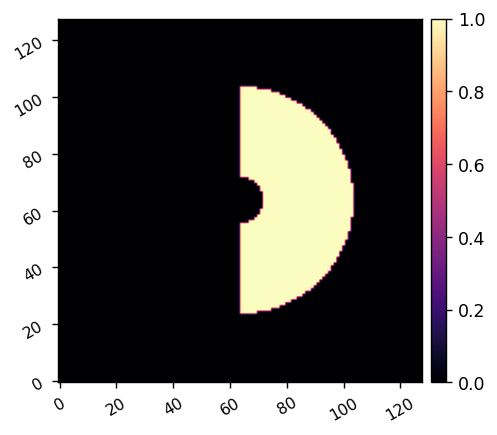

(640, 2312)

(160, 2)

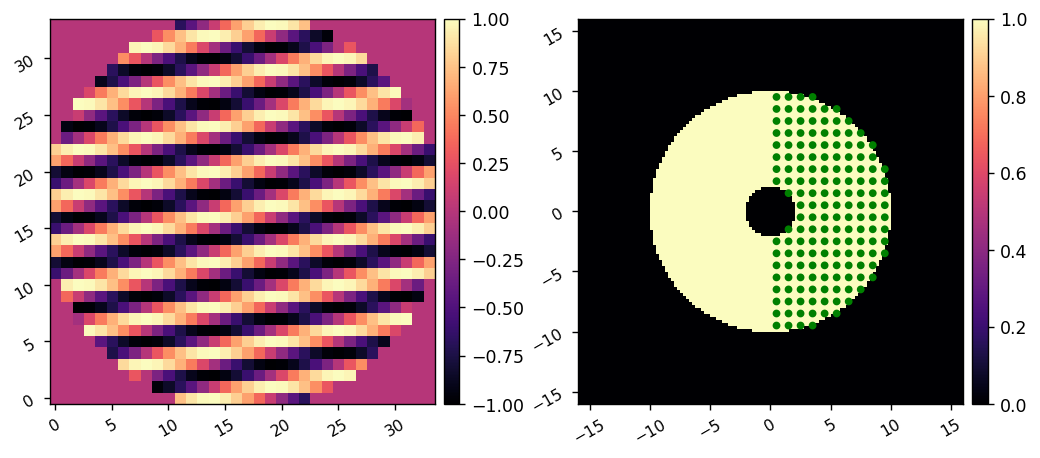

In [8]:
reload(utils)
fourier_mask = utils.create_annular_focal_plane_mask(svc, inner_radius=2, outer_radius=10, edge=0, plot=True)

calib_modes, fs = utils.create_fourier_modes(svc, fourier_mask, fourier_sampling=1, return_fs=True, ndms=2) 
nmodes = calib_modes.shape[0]
nf = calib_modes.shape[0]//2
display(calib_modes.shape, fs.shape)

patches = []
for f in fs:
    center = (f[0], f[1])
    radius = 0.25
    patches.append(Circle(center, radius, fill=True, color='g'))

imshow2(calib_modes[5, :svc.Nact**2].reshape(svc.Nact,svc.Nact), control_mask, 
             patches2=patches, pxscl2=svc.psf_pixelscale_lamD)
# wfssvc.imshow1(ref_im, lognorm=True, pxscl=svc.psf_pixelscale_lamD, patches=patches)


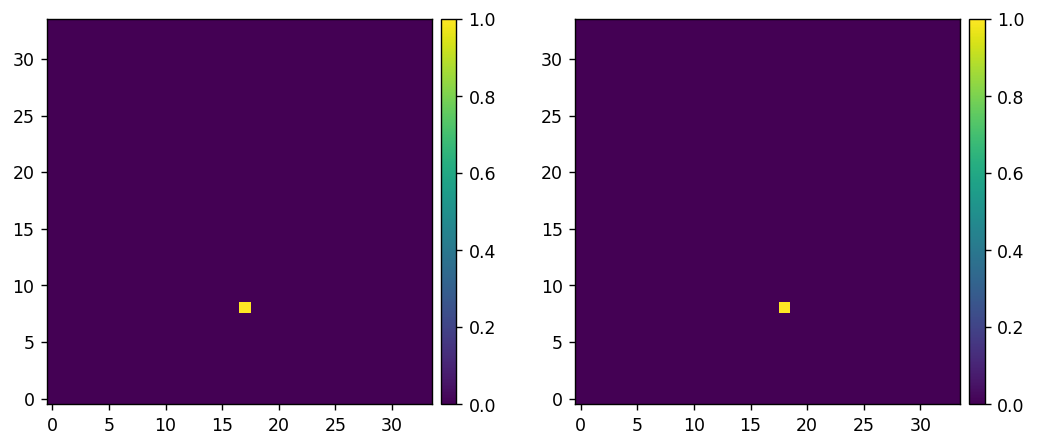

In [9]:
probe_modes = utils.create_poke_probes(poke_indices=[(svc.Nact//2, svc.Nact//4), (svc.Nact//2+1, svc.Nact//4)], 
                                            Nact=svc.Nact, plot=True)

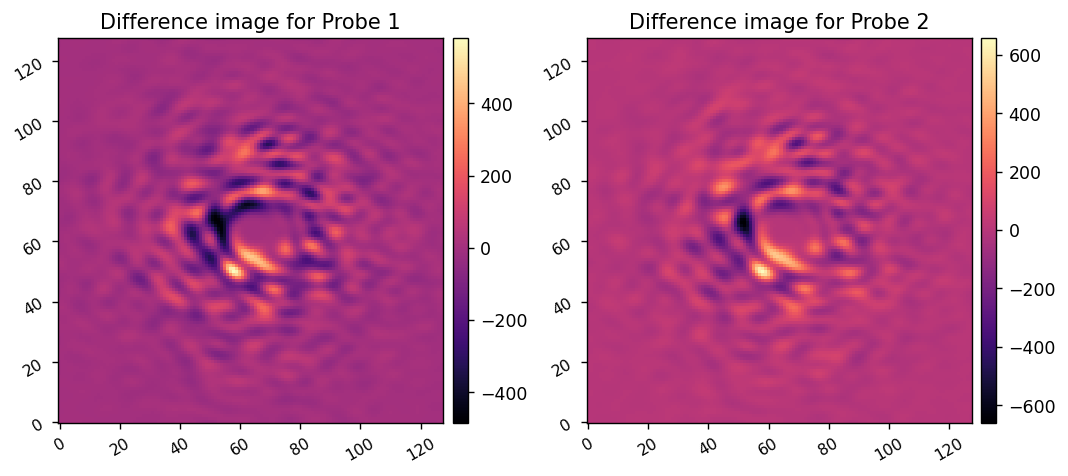

In [12]:
reload(iefc_2dm)

probe_amp = 2.5e-8
calib_amp = 5e-9

svc.reset_dms()

differential_images, single_images = iefc_2dm.take_measurement(svc, 
                                                                   probe_modes, probe_amp, 
                                                                   return_all=True)
ims = differential_images.reshape(probe_modes.shape[0], svc.npsf, svc.npsf)
imshow2(ims[0], ims[1], 'Difference image for Probe 1', 'Difference image for Probe 2')

Calibrating iEFC...


	Calibrated mode 640/640 in 3575.511s
Calibration complete.


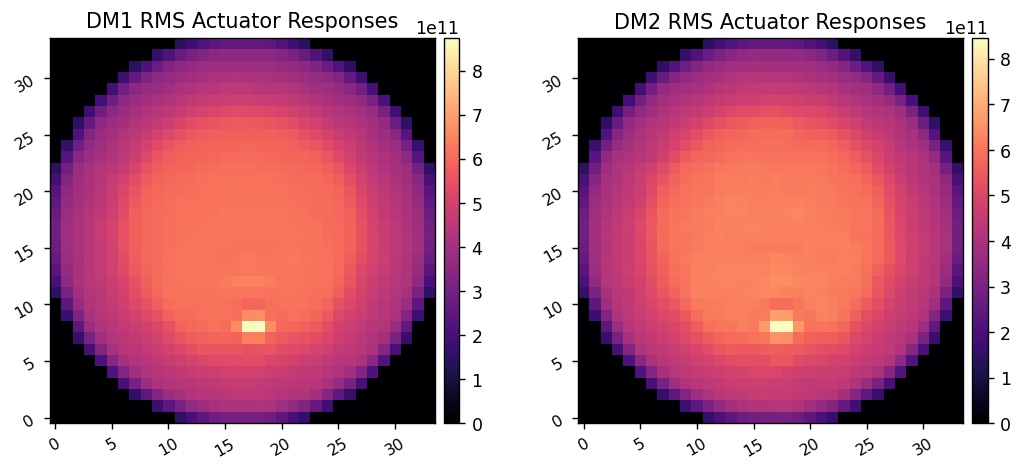

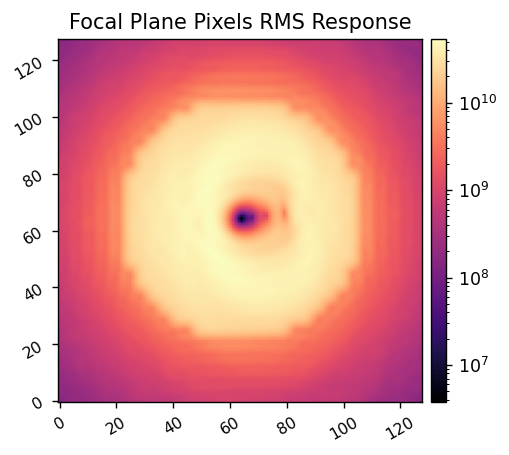

In [13]:
reload(iefc_2dm)
response_matrix, response_cube = iefc_2dm.calibrate(svc, 
                                                         control_mask,
                                                         probe_amp, probe_modes, 
                                                         calib_amp, calib_modes, 
                                                         return_all=True)

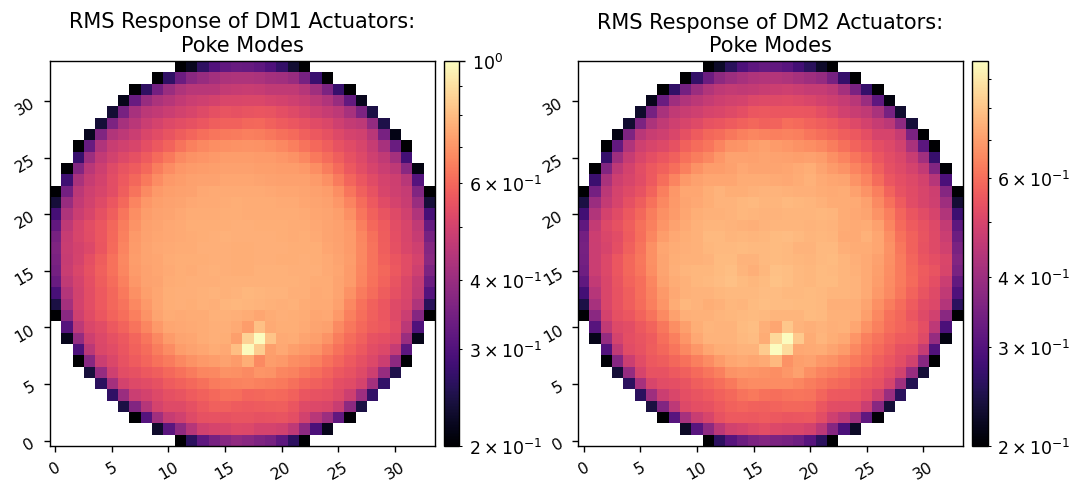

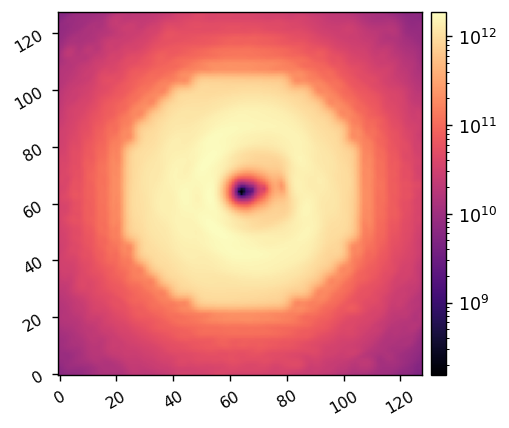

In [22]:
response_matrix.shape

dm_response = xp.sqrt(xp.mean(response_matrix.dot(xp.array(calib_modes))**2, axis=0))
dm1_response = dm_response[:svc.Nact**2].reshape(svc.Nact, svc.Nact)/dm_response.max()
dm2_response = dm_response[svc.Nact**2:].reshape(svc.Nact, svc.Nact)/dm_response.max()
imshow2(dm1_response, dm2_response, 
        'RMS Response of DM1 Actuators:\nPoke Modes', 'RMS Response of DM2 Actuators:\nPoke Modes',
        lognorm=True, vmin1=0.2, vmin2=0.2,
        )

fp_response = xp.sqrt(xp.sum(abs(response_cube)**2, axis=(0,1))).reshape(svc.npsf, svc.npsf)
imshow1(fp_response, lognorm=True)

In [24]:
data_dir = iefc_2dm.iefc_data_dir
response_dir = data_dir/'response-data'

In [25]:
reload(utils)

<module 'utils' from '/home/kianmilani/Projects/roman-cgi-iefc/utils.py'>

In [27]:
date = 20231023
# utils.save_pickle(f'hcipy_svc_{date}.pkl', svc)

utils.save_fits(response_dir/f'hcipy_svc_iefc_2dm_response_matrix_{date}.fits', response_matrix)
utils.save_fits(response_dir/f'hcipy_svc_iefc_2dm_response_cube_{date}.fits', response_cube)

Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/hcipy_svc_iefc_2dm_response_matrix_20231023.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/hcipy_svc_iefc_2dm_response_cube_20231023.fits


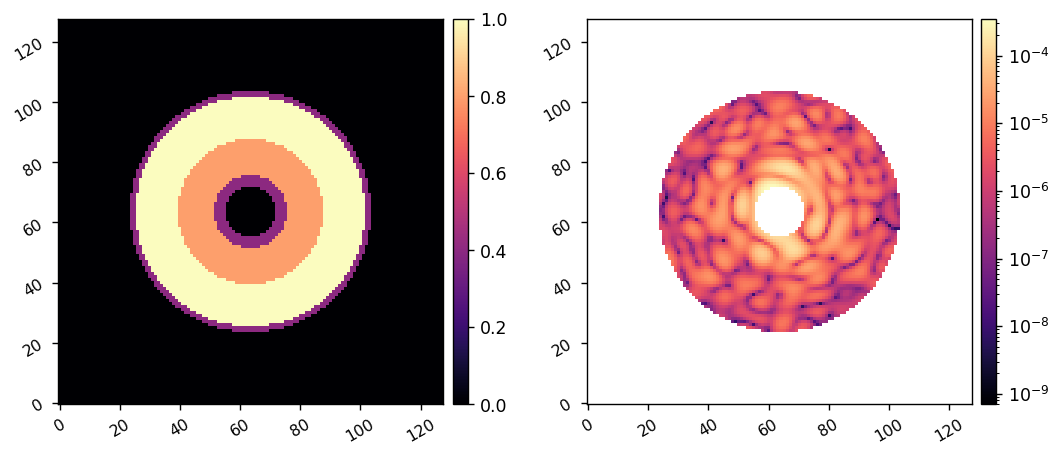

1.0997250859448004e-05


In [14]:
reload(utils)
roi1 = utils.create_annular_focal_plane_mask(svc, inner_radius=3, outer_radius=6, edge=None,)
roi2 = utils.create_annular_focal_plane_mask(svc, inner_radius=2, outer_radius=10, edge=None)
roi3 = utils.create_annular_focal_plane_mask(svc, inner_radius=6, outer_radius=9.5, edge=None)

relative_weight_1 = 0.8
relative_weight_2 = 0.4
weight_map = roi3 + relative_weight_1*(roi1*~roi3) + relative_weight_2*(roi2*~roi1*~roi3)
control_mask = weight_map>0
imshow2(weight_map, control_mask*ref_im, lognorm2=True)
mean_ni = xp.mean(ref_im[control_mask])
print(mean_ni)

In [15]:
images = xp.array([ref_im])
dm1_commands = xp.array([svc.get_dm1()])
dm2_commands = xp.array([svc.get_dm2()])

In [39]:
reload(utils)
reg_cond = 1e-4/2
# reg_cond = 1e-3
control_matrix = utils.WeightedLeastSquares(response_matrix, rcond=reg_cond, weight_map=weight_map, algorithm='iefc', nprobes=2)
# control_matrix = utils.TikhonovInverse(response_matrix, reg_cond)
# probe_amp = 2e-8

Running iEFC...
	Closed-loop iteration 49 / 51


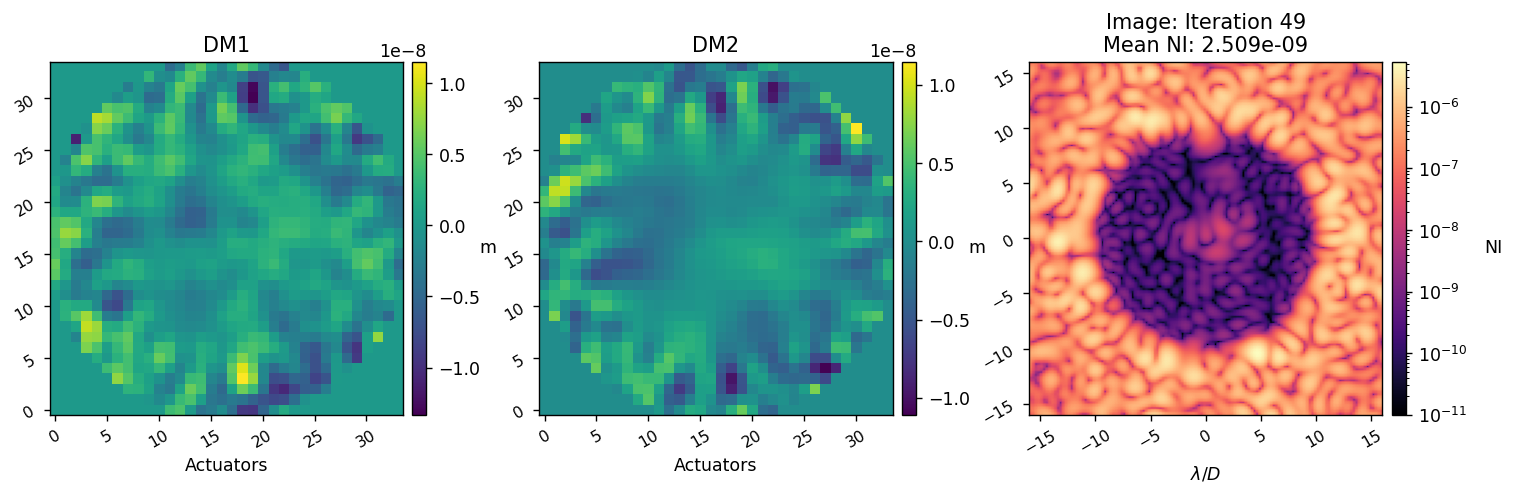

	Closed-loop iteration 50 / 51


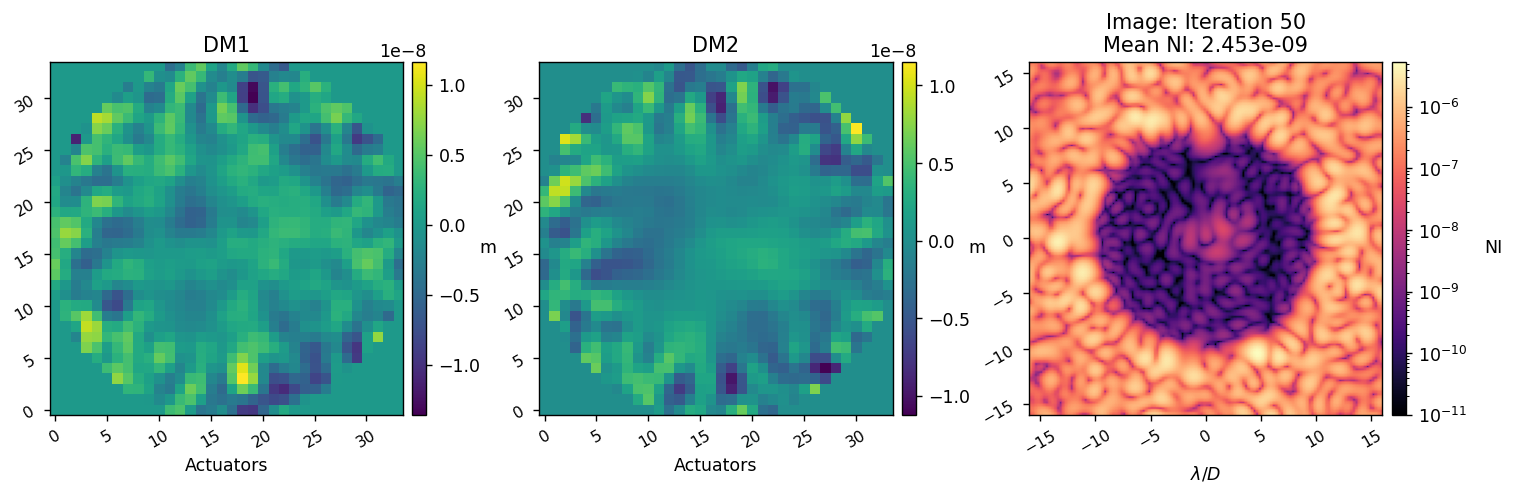

	Closed-loop iteration 51 / 51


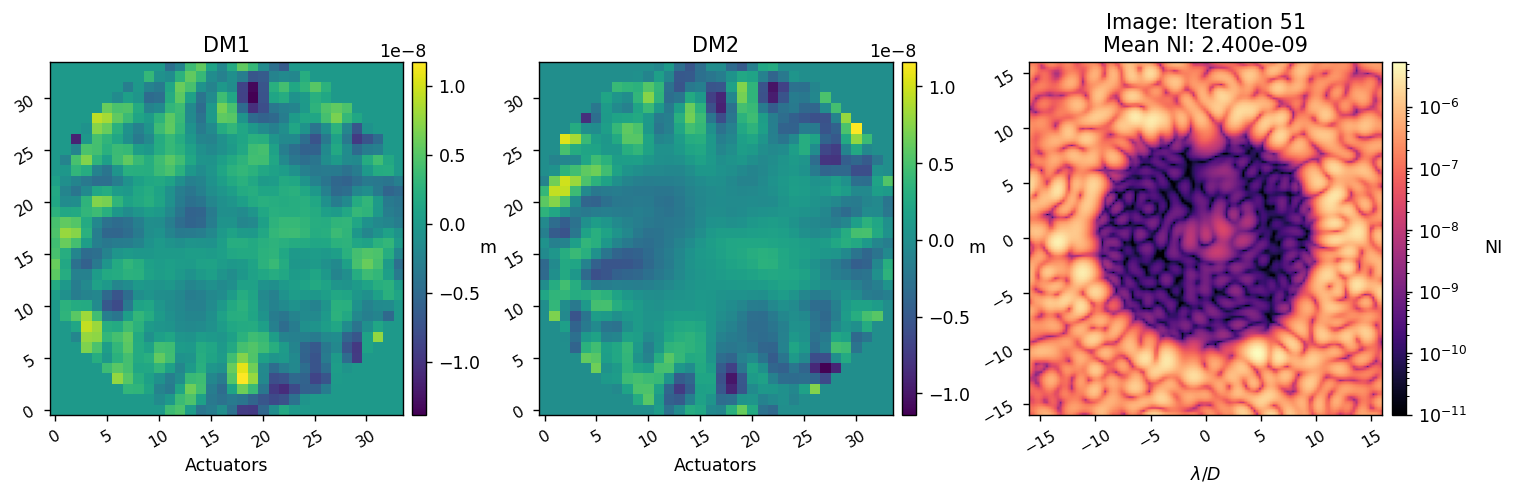

Closed loop for given control matrix completed in 12.251s.


In [44]:
reload(iefc_2dm)

reload(utils)

probe_amp = 5e-9

images, dm1_commands, dm2_commands = iefc_2dm.run(svc, 
                                          control_matrix,
                                          probe_modes, 
                                          probe_amp, 
                                          calib_modes,
                                          control_mask, 
                                          num_iterations=3, 
                                          loop_gain=0.5, 
                                          leakage=0,
                                          plot_all=True,
                                         plot_radial_contrast=False,
                                        old_images=images,
                                        old_dm1_commands=dm1_commands,
                                        old_dm2_commands=dm2_commands,
                                         )


In [46]:
date = 20231024

In [47]:
utils.save_fits(response_dir/f'hcipy_svc_dm1_commands_{date}.fits', dm1_commands)
utils.save_fits(response_dir/f'hcipy_svc_dm2_commands_{date}.fits', dm2_commands)
utils.save_fits(response_dir/f'hcipy_svc_images_{date}.fits', images)

Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/hcipy_svc_dm1_commands_20231024.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/hcipy_svc_dm2_commands_20231024.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/hcipy_svc_images_20231024.fits


In [10]:
from matplotlib.patches import Circle

In [17]:
probe_inds_1 = np.argwhere(probe_modes[0])[0]
probe_inds_2 = np.argwhere(probe_modes[1])[0]

2.4530784337259737e-09


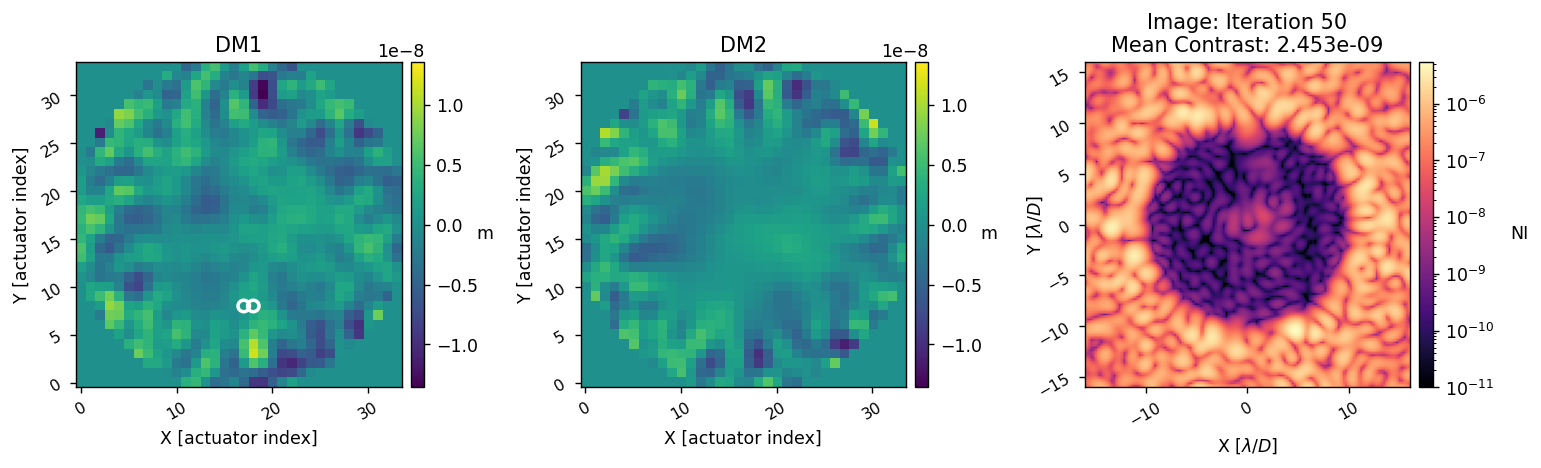

In [26]:
date = 20231024
dm1s = fits.getdata(response_dir/f'hcipy_svc_dm1_commands_{date}.fits')
dm2s = fits.getdata(response_dir/f'hcipy_svc_dm2_commands_{date}.fits')
images = fits.getdata(response_dir/f'hcipy_svc_images_{date}.fits')

contrast = np.mean(images[:,control_mask], axis=1)

i = np.argmin(contrast)
i = 50
print(contrast[i])

patches = [Circle((probe_inds_1[1],probe_inds_1[0]), 0.6, color='w', fill=False, linewidth=2),
           Circle((probe_inds_2[1],probe_inds_2[0]), 0.6, color='w', fill=False, linewidth=2)]

dm_max = np.max(np.abs(np.concatenate([dm1s[i], dm2s[i]])))
dm1_rms = np.sqrt(np.mean(dm1s[i][svc.dm_mask.astype(bool)]**2))*1e9
dm2_rms = np.sqrt(np.mean(dm2s[i][svc.dm_mask.astype(bool)]**2))*1e9
dm1_p2v = (np.max(dm1s[i]) - np.min(dm1s[i]))*1e9
dm2_p2v = (np.max(dm2s[i]) - np.min(dm2s[i]))*1e9
fig, ax = imshow3(dm1s[i], dm2s[i], images[i], 
        f'DM1', 
        f'DM2',
        f'Image: Iteration {i}\nMean Contrast: {contrast[i]:.3e}',
        cmap1='viridis', cmap2='viridis',
        cbar1_label='m', cbar2_label='m', cbar3_label='NI',
        xlabel1='X [actuator index]', xlabel2='X [actuator index]', xlabel3='X [$\lambda/D$]', 
        pxscl3=svc.psf_pixelscale_lamD,
        vmin1=-dm_max, vmax1=dm_max, vmin2=-dm_max, vmax2=dm_max, 
        lognorm3=True, vmin3=1e-11, 
        wspace=0.45,
        patches1=patches,
        display_fig=False, return_fig=True)
ax[2].set_ylabel('Y [$\lambda/D$]', labelpad=-5)
ax[0].set_ylabel('Y [actuator index]', labelpad=5)
ax[1].set_ylabel('Y [actuator index]', labelpad=5)
fig.savefig('figs/hcipy_svc_dark_hole.pdf', format='pdf', bbox_inches="tight")
display(fig)